In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
class CombinedMobileNet(nn.Module):
    def __init__(self, num_classes):
        super(CombinedMobileNet, self).__init__()
        
        self.mobilenetv3_large = models.mobilenet_v3_large(pretrained=True)
        self.mobilenetv3_small = models.mobilenet_v3_small(pretrained=True)
        
        for param in self.mobilenetv3_large.parameters():
            param.requires_grad = False
        for param in self.mobilenetv3_small.parameters():
            param.requires_grad = False
        
        self.mobilenetv3_large.classifier = nn.Identity()
        self.mobilenetv3_small.classifier = nn.Identity()
        
        self.combined_feature_dim = 960 + 576 
        
        self.classifier = nn.Sequential(
            nn.Linear(self.combined_feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        features_large = self.mobilenetv3_large(x)
        features_small = self.mobilenetv3_small(x)
        
        combined_features = torch.cat((features_large, features_small), dim=1)
        
        output = self.classifier(combined_features)
        return output

In [3]:
train_dir = 'real-vs-fake-classification/train'
val_dir = 'real-vs-fake-classification/Validation'

In [4]:
transform = transforms.Compose(
    [transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [5]:
trainset = ImageFolder(root=train_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

valset = ImageFolder(root=val_dir, transform=transform)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

In [6]:
classes = trainset.classes
num_classes = len(classes)

In [7]:
model = CombinedMobileNet(num_classes)

c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weigh

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CombinedMobileNet(
  (mobilenetv3_large): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Con

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [10]:
def train_model(model, trainloader, criterion, optimizer, num_epochs=15):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies

In [11]:
def validate_model(model, valloader, criterion):
    model.eval()
    val_losses = []
    val_accuracies = []
    all_labels = []
    all_predictions = []
    
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    val_loss /= len(valloader)
    accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)
    print(f'Validation Loss: {val_loss:.3f}, Accuracy: {accuracy:.2f}%')
    
    return val_losses, val_accuracies, all_labels, all_predictions

In [12]:
num_epochs = 15
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss, train_accuracy = train_model(model, trainloader, criterion, optimizer, num_epochs=1)
    val_loss, val_accuracy, all_labels, all_predictions = validate_model(model, valloader, criterion)
    train_losses.extend(train_loss)
    train_accuracies.extend(train_accuracy)
    val_losses.extend(val_loss)
    val_accuracies.extend(val_accuracy)
    
#11m 36.7s

Epoch 1/15
Epoch 1, Loss: 0.722, Accuracy: 56.98%
Validation Loss: 0.689, Accuracy: 56.25%
Epoch 2/15
Epoch 1, Loss: 0.665, Accuracy: 60.48%
Validation Loss: 0.703, Accuracy: 50.78%
Epoch 3/15
Epoch 1, Loss: 0.642, Accuracy: 63.58%
Validation Loss: 0.683, Accuracy: 58.98%
Epoch 4/15
Epoch 1, Loss: 0.624, Accuracy: 65.75%
Validation Loss: 0.670, Accuracy: 58.01%
Epoch 5/15
Epoch 1, Loss: 0.617, Accuracy: 65.00%
Validation Loss: 0.674, Accuracy: 60.16%
Epoch 6/15
Epoch 1, Loss: 0.609, Accuracy: 67.00%
Validation Loss: 0.670, Accuracy: 59.77%
Epoch 7/15
Epoch 1, Loss: 0.611, Accuracy: 65.58%
Validation Loss: 0.672, Accuracy: 58.98%
Epoch 8/15
Epoch 1, Loss: 0.610, Accuracy: 68.50%
Validation Loss: 0.644, Accuracy: 63.87%
Epoch 9/15
Epoch 1, Loss: 0.593, Accuracy: 68.67%
Validation Loss: 0.669, Accuracy: 62.30%
Epoch 10/15
Epoch 1, Loss: 0.574, Accuracy: 68.50%
Validation Loss: 0.648, Accuracy: 62.89%
Epoch 11/15
Epoch 1, Loss: 0.608, Accuracy: 67.42%
Validation Loss: 0.638, Accuracy: 64.0

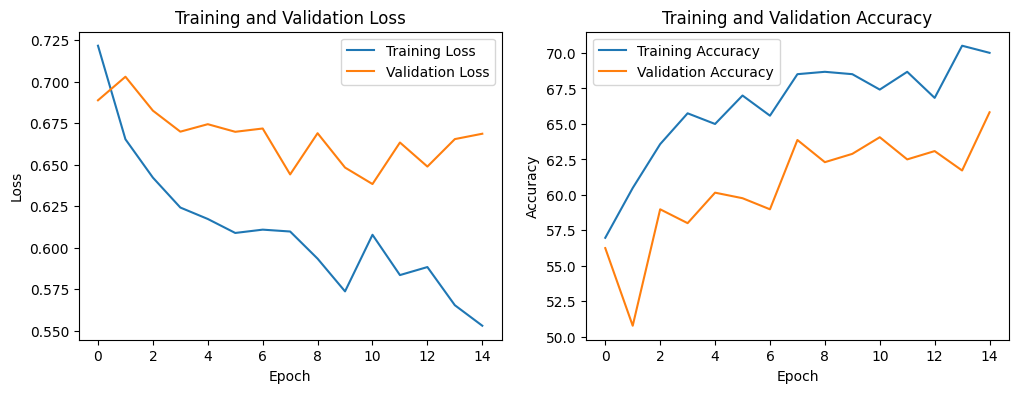

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

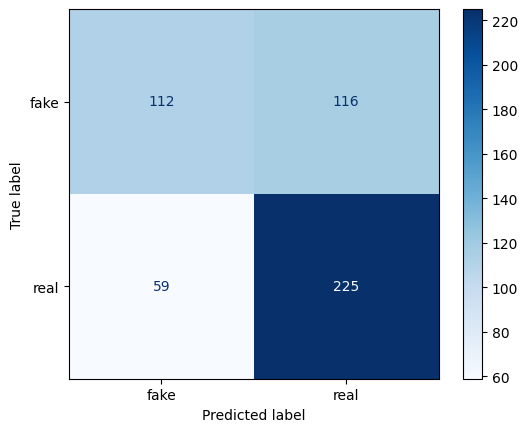

In [14]:
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()